Desarrollar Indice

Importación de librerías

In [10]:
#Machine Learning y ETL
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats import diagnostic as diag
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

#requeridos para traer datos de la PI WEB API
from pandas import json_normalize
from urllib.parse import urlparse
from requests.auth import HTTPBasicAuth
from requests_kerberos import HTTPKerberosAuth

Funciones

In [11]:
def plot_distribution(df, column):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Histograma de {column}')

    plt.subplot(1, 2, 2)
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Gráfico Q-Q de {column}')

    plt.show()

Ingrese el path de su csv

In [12]:
df = pd.read_csv(r"Data\MC-WTG13.csv", header=0, index_col=0)

Info DataSet

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8987 entries, 2023-01-01T03:00:00Z to 2023-04-27T04:40:00Z
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient.WindDir      8987 non-null   float64
 1   Ambient.WindSpeed    8987 non-null   float64
 2   Grid.Power           8987 non-null   float64
 3   Ambient.Temperature  8983 non-null   float64
dtypes: float64(4)
memory usage: 351.1+ KB


Descripción de Estadísticos Basicos del DataSet

In [5]:
df.describe()

,Ambient.WindDir,Ambient.WindSpeed,Grid.Power,Ambient.Temperature
count,8987.000000,8987.000000,8987.000000,8983.000000
mean,184.477017,8.102771,1635.301172,21.193254
std,121.231617,2.881985,1164.356527,6.332740
min,0.350000,2.490000,100.200000,6.000000
25%,74.065000,5.820000,564.680000,17.000000
50%,177.410000,7.660000,1361.600000,20.000000
75%,316.790000,9.890000,2738.995000,25.000000
max,359.830000,23.490000,3652.990000,39.000000


Chequeo de Nulos

In [3]:
df.isnull().sum()/df.shape[0]*100

Ambient.WindDir        0.000000
Ambient.WindSpeed      0.000000
Grid.Power             0.000000
Ambient.Temperature    0.044509
dtype: float64

Distribución de Variables

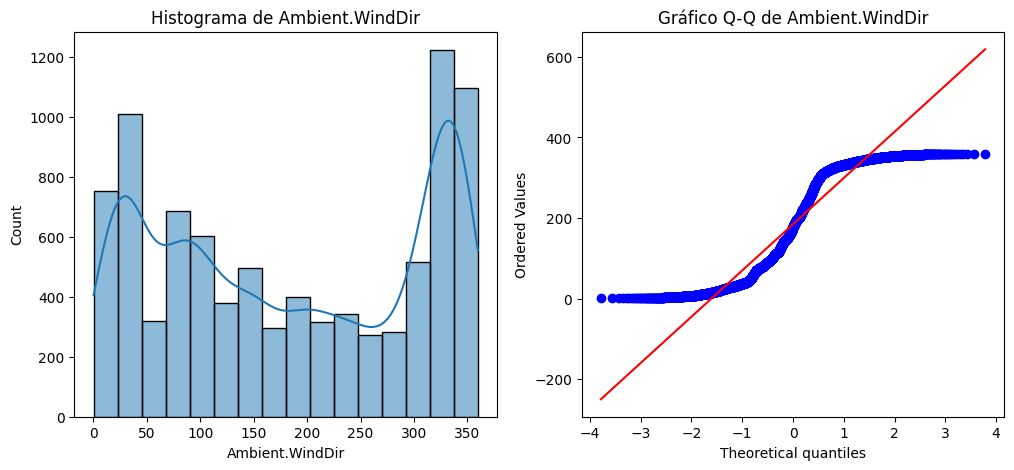

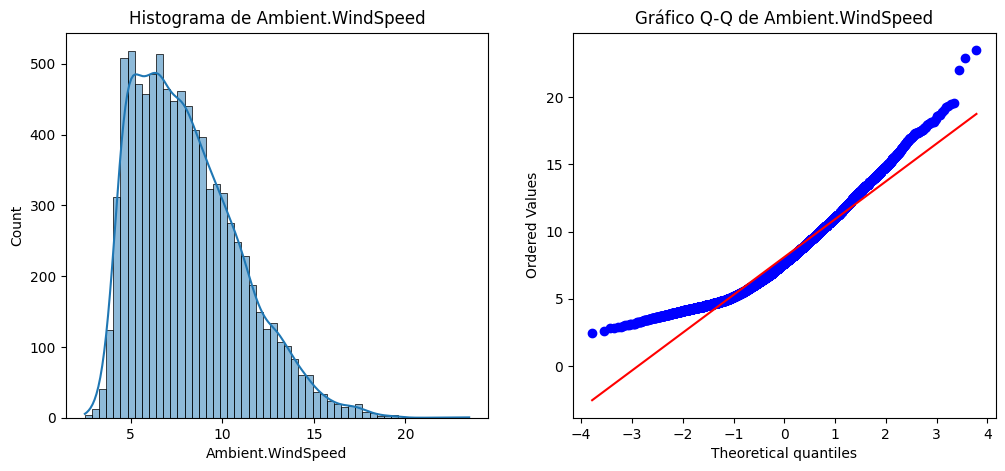

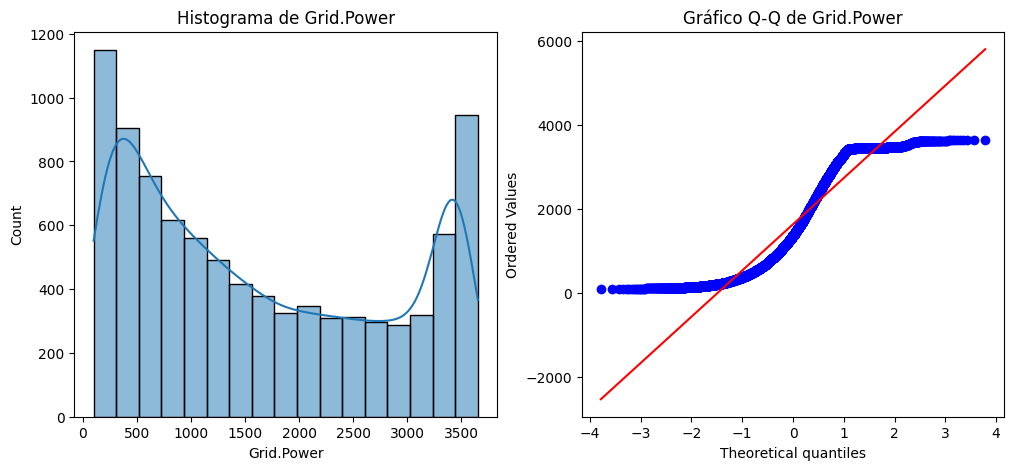

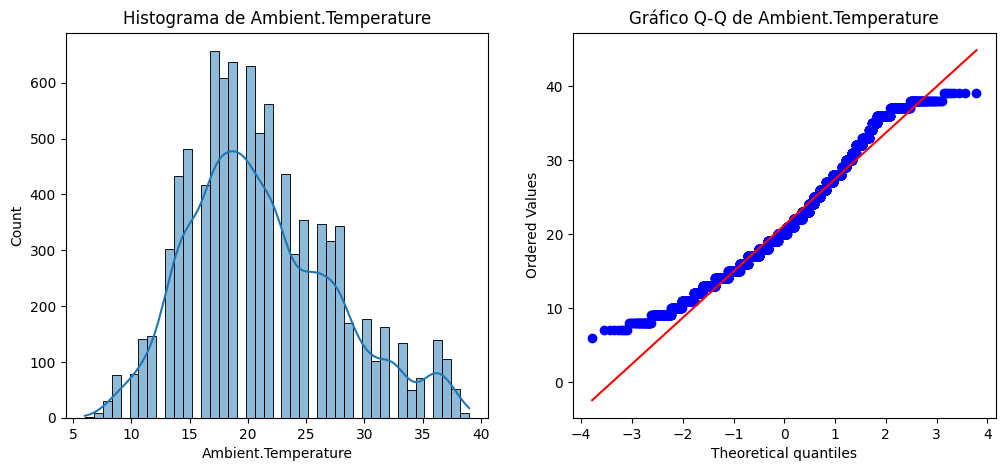

In [10]:
for column in df.select_dtypes(include=[np.number]).columns:
    plot_distribution(df, column)

Tratamiento de datos

In [16]:
df.fillna(method='ffill', inplace=True)

C:\Users\jadurian\AppData\Local\Temp\ipykernel_17164\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [17]:
print(df.isnull().sum())

Ambient.WindDir        0
Ambient.WindSpeed      0
Grid.Power             0
Ambient.Temperature    0
dtype: int64


## Especificacion del target y variables independientes

Importante definir del DataSet, cual variable es el target y cuales son los términos independientes.

In [18]:
X = df.drop("Grid.Power", axis=1) # X es un dataframe que contiene únicamente a las variables independientes o inputs del modelo
y = df[["Grid.Power"]] # y es la variable objetivo a regresionar o target

Matriz de correlación de variables

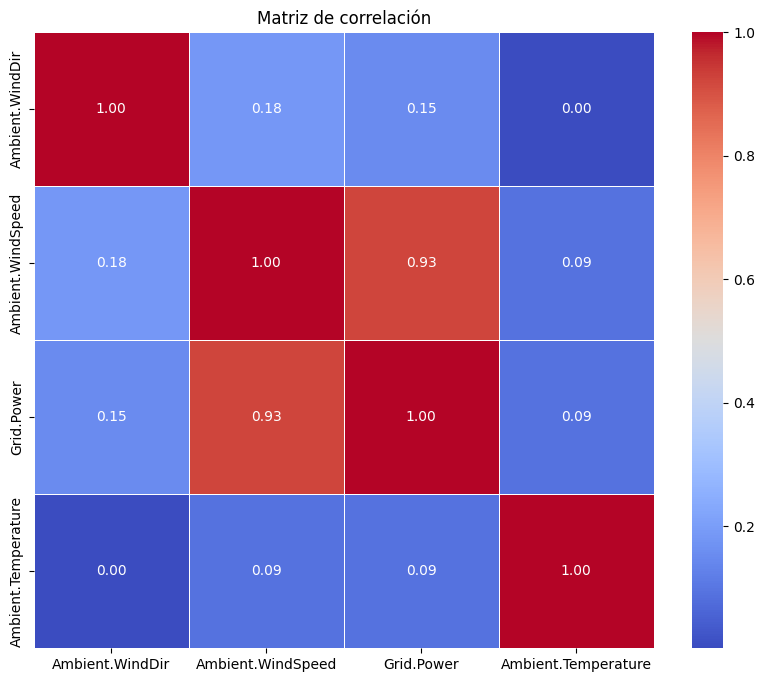

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Testeo de resultados para distintos grados de polinomio

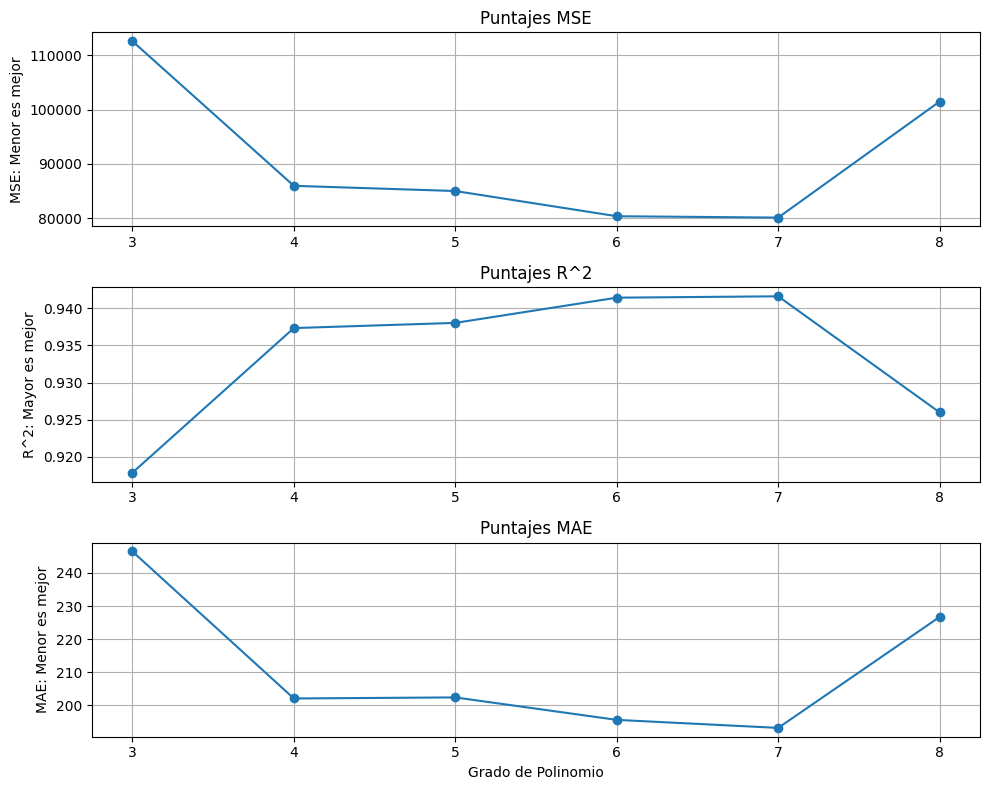

In [31]:
grados_pol = [3,4,5,6,7,8]
plt_mean_squared_error = []
lista_puntajes = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mse_scores = []
r2_scores = []
mae_scores = []

for degree in grados_pol:
    # Crear el pipeline con PolynomialFeatures y LinearRegression
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    
    # Entrenar el modelo utilizando los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular los puntajes
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Crear gráficos separados para cada métrica
plt.figure(figsize=(10, 8))

# Gráfico para MSE
plt.subplot(3, 1, 1)
plt.plot(grados_pol, mse_scores, marker='o')
plt.ylabel('MSE: Menor es mejor')
plt.title('Puntajes MSE')
plt.grid(True)

# Gráfico ara R2
plt.subplot(3, 1, 2)
plt.plot(grados_pol, r2_scores, marker='o')
plt.ylabel('R^2: Mayor es mejor')
plt.title('Puntajes R^2')
plt.grid(True)

# Gráfico para MAE
plt.subplot(3, 1, 3)
plt.plot(grados_pol, mae_scores, marker='o')
plt.ylabel('MAE: Menor es mejor')
plt.xlabel('Grado de Polinomio')
plt.title('Puntajes MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Elegido el grado con mejores resultados, seteamos el polinomio en el argumento "degree=X"

In [26]:
#Seteo el polinomio para grado seleccionado
model = make_pipeline(PolynomialFeatures(degree=4, interaction_only=False), LinearRegression())

# Entrenar el modelo utilizando los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

MSE:  85946.98829636717
R2:  0.9373171191666478
MAE:  202.0539839980669


Resultados

In [29]:
# Calcular los puntajes
print("MSE: ",mean_squared_error(y_test, y_pred))
print("R2: ",r2_score(y_test, y_pred))
print("MAE: ",mean_absolute_error(y_test, y_pred))

MSE:  101478.97561166927
R2:  0.9259893259619223
MAE:  226.69954826424348


In [27]:
y_test.shape

(1798, 1)

In [28]:
y_pred.shape

(1798, 1)

## Cross Validation

Método de Validación Cruzada para asegurarnos la generalidad del modelo en distintos folds del DataSet

In [30]:
# Realizar la validación cruzada con 5 folds
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Imprimir los puntajes de R^2 para cada fold
print("Puntajes de R^2 para cada fold:", scores)

# Imprimir el promedio de los puntajes de R^2
print("Promedio de R^2:", np.mean(scores))

Puntajes de R^2 para cada fold: [ 0.84744773  0.15885847  0.94004041  0.89398378 -4.64578966]
Promedio de R^2: -0.36109185352563145


Plot resultados Validación Cruzada

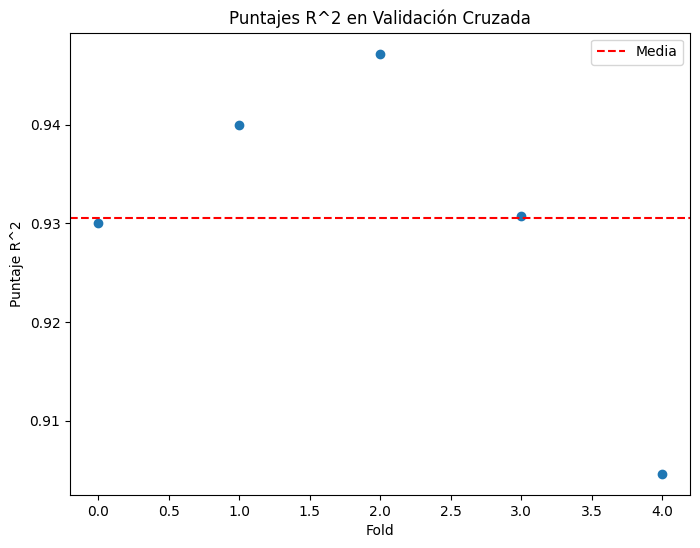

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(scores)), scores)
plt.axhline(scores.mean(), color='red', linestyle='dashed', label='Media')
plt.xlabel('Fold')
plt.ylabel('Puntaje R^2')
plt.title('Puntajes R^2 en Validación Cruzada')
plt.legend()
plt.show()

Desarrollo para llegar al polinomio

In [32]:
poly_model = model[0]
lineal_model = model[1]

features_names_in = poly_model.feature_names_in_
n_output_features_ = poly_model.n_output_features_



print(n_output_features_)
print(features_names_in[:])

#print(len(model[0].get_feature_names_out(model[0].feature_names_in_[:])))

#print(model[0].get_feature_names_out(["Ambient.WindSpeed","Ambient.Temperature","Ambient.WindDir"])

35
['Ambient.WindSpeed' 'Ambient.WindDir' 'Ambient.Temperature']


In [61]:
# Obtener el término independiente (intercept) del modelo ajustado
intercept = model[1].intercept_
intercept = str(intercept)
# Obtener los coeficientes de todas las características polinómicas generadas por PolynomialFeatures
coeficientes = model[1].coef_[0]

# Obtener los nombres de todas las características generadas por PolynomialFeatures
nombres_caracteristicas = poly_model.get_feature_names_out()

In [67]:
nombres_caracteristicas

array(['1', 'Ambient.WindSpeed', 'Ambient.WindDir', 'Ambient.Temperature',
       'Ambient.WindSpeed^2', 'Ambient.WindSpeed Ambient.WindDir',
       'Ambient.WindSpeed Ambient.Temperature', 'Ambient.WindDir^2',
       'Ambient.WindDir Ambient.Temperature', 'Ambient.Temperature^2',
       'Ambient.WindSpeed^3', 'Ambient.WindSpeed^2 Ambient.WindDir',
       'Ambient.WindSpeed^2 Ambient.Temperature',
       'Ambient.WindSpeed Ambient.WindDir^2',
       'Ambient.WindSpeed Ambient.WindDir Ambient.Temperature',
       'Ambient.WindSpeed Ambient.Temperature^2', 'Ambient.WindDir^3',
       'Ambient.WindDir^2 Ambient.Temperature',
       'Ambient.WindDir Ambient.Temperature^2', 'Ambient.Temperature^3',
       'Ambient.WindSpeed^4', 'Ambient.WindSpeed^3 Ambient.WindDir',
       'Ambient.WindSpeed^3 Ambient.Temperature',
       'Ambient.WindSpeed^2 Ambient.WindDir^2',
       'Ambient.WindSpeed^2 Ambient.WindDir Ambient.Temperature',
       'Ambient.WindSpeed^2 Ambient.Temperature^2',
       'Ambi

In [62]:
lista_sin_espacios = [elemento.replace(" ", "*") for elemento in nombres_caracteristicas]

In [36]:
lista_sin_espacios[:]

['1',
 'Ambient.WindSpeed',
 'Ambient.WindDir',
 'Ambient.Temperature',
 'Ambient.WindSpeed^2',
 'Ambient.WindSpeed*Ambient.WindDir',
 'Ambient.WindSpeed*Ambient.Temperature',
 'Ambient.WindDir^2',
 'Ambient.WindDir*Ambient.Temperature',
 'Ambient.Temperature^2',
 'Ambient.WindSpeed^3',
 'Ambient.WindSpeed^2*Ambient.WindDir',
 'Ambient.WindSpeed^2*Ambient.Temperature',
 'Ambient.WindSpeed*Ambient.WindDir^2',
 'Ambient.WindSpeed*Ambient.WindDir*Ambient.Temperature',
 'Ambient.WindSpeed*Ambient.Temperature^2',
 'Ambient.WindDir^3',
 'Ambient.WindDir^2*Ambient.Temperature',
 'Ambient.WindDir*Ambient.Temperature^2',
 'Ambient.Temperature^3',
 'Ambient.WindSpeed^4',
 'Ambient.WindSpeed^3*Ambient.WindDir',
 'Ambient.WindSpeed^3*Ambient.Temperature',
 'Ambient.WindSpeed^2*Ambient.WindDir^2',
 'Ambient.WindSpeed^2*Ambient.WindDir*Ambient.Temperature',
 'Ambient.WindSpeed^2*Ambient.Temperature^2',
 'Ambient.WindSpeed*Ambient.WindDir^3',
 'Ambient.WindSpeed*Ambient.WindDir^2*Ambient.Temperature'

In [47]:
lista2 = list()

for i in range(len(lista_sin_espacios)):
    b = str()
    elemento = lista_sin_espacios[i]
    
    if "*" in elemento and "^" in elemento:

        elemento = elemento.replace("*", "*'")

        elemento = elemento.replace("^", "'^")
        b = elemento
    
    elif "^" in elemento and not("*" in elemento):
        elemento = elemento.replace("^", "'^")
        b = elemento

    elif "*" in elemento and not("^" in elemento):
        elemento = elemento.replace("*", "'*'")

        b = elemento

    else:
        b = elemento
    
    lista2.append(b)

lista2


['1',
 'Ambient.WindSpeed',
 'Ambient.WindDir',
 'Ambient.Temperature',
 "Ambient.WindSpeed'^2",
 "Ambient.WindSpeed'*'Ambient.WindDir",
 "Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.WindDir'^2",
 "Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.Temperature'^2",
 "Ambient.WindSpeed'^3",
 "Ambient.WindSpeed'^2*'Ambient.WindDir",
 "Ambient.WindSpeed'^2*'Ambient.Temperature",
 "Ambient.WindSpeed*'Ambient.WindDir'^2",
 "Ambient.WindSpeed'*'Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.WindSpeed*'Ambient.Temperature'^2",
 "Ambient.WindDir'^3",
 "Ambient.WindDir'^2*'Ambient.Temperature",
 "Ambient.WindDir*'Ambient.Temperature'^2",
 "Ambient.Temperature'^3",
 "Ambient.WindSpeed'^4",
 "Ambient.WindSpeed'^3*'Ambient.WindDir",
 "Ambient.WindSpeed'^3*'Ambient.Temperature",
 "Ambient.WindSpeed'^2*'Ambient.WindDir'^2",
 "Ambient.WindSpeed'^2*'Ambient.WindDir*'Ambient.Temperature",
 "Ambient.WindSpeed'^2*'Ambient.Temperature'^2",
 "Ambient.WindSpeed*'Ambient.WindDir'^3",
 "Ambient.Wind

In [56]:
def agregar_comilla_astrisco(lista_strings):
    nueva_lista = []

    for elemento in lista_strings:
        pos_ast = elemento.find('*')

        if pos_ast > 0 and elemento[pos_ast - 1].isalpha():
            nuevo_elemento = elemento[:pos_ast] + "'" + elemento[pos_ast:]
            nueva_lista.append(nuevo_elemento)
        else:
            nueva_lista.append(elemento)

    return nueva_lista

lista_con_comilla = agregar_comilla_astrisco(lista2)
lista_con_comilla

['1',
 'Ambient.WindSpeed',
 'Ambient.WindDir',
 'Ambient.Temperature',
 "Ambient.WindSpeed'^2",
 "Ambient.WindSpeed'*'Ambient.WindDir",
 "Ambient.WindSpeed'*'Ambient.Temperature",
 "Ambient.WindDir'^2",
 "Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.Temperature'^2",
 "Ambient.WindSpeed'^3",
 "Ambient.WindSpeed'^2*'Ambient.WindDir",
 "Ambient.WindSpeed'^2*'Ambient.Temperature",
 "Ambient.WindSpeed'*'Ambient.WindDir'^2",
 "Ambient.WindSpeed'*'Ambient.WindDir'*'Ambient.Temperature",
 "Ambient.WindSpeed'*'Ambient.Temperature'^2",
 "Ambient.WindDir'^3",
 "Ambient.WindDir'^2*'Ambient.Temperature",
 "Ambient.WindDir'*'Ambient.Temperature'^2",
 "Ambient.Temperature'^3",
 "Ambient.WindSpeed'^4",
 "Ambient.WindSpeed'^3*'Ambient.WindDir",
 "Ambient.WindSpeed'^3*'Ambient.Temperature",
 "Ambient.WindSpeed'^2*'Ambient.WindDir'^2",
 "Ambient.WindSpeed'^2*'Ambient.WindDir*'Ambient.Temperature",
 "Ambient.WindSpeed'^2*'Ambient.Temperature'^2",
 "Ambient.WindSpeed'*'Ambient.WindDir'^3",
 "Ambient.

In [49]:
print(coeficientes.shape)

print(nombres_caracteristicas.shape)

(35,)
(35,)


In [57]:
poli = f"{intercept[1:-1]}+"

for i, coef in enumerate(coeficientes):
    
    #print(lista2[i])
    #print(coef)
    

    if lista_con_comilla[i][0].isalpha() and lista_con_comilla[i][-1].isdigit():

            poli += f"{coef:.20f}*'{lista_con_comilla[i]}+"
            #print(f"'{lista2[i]}+{coef}")

    else :
        poli += f"{coef:.20f}*'{lista_con_comilla[i]}'+"

        #print(f"{coef:f}")
        #print(coef)


In [58]:
poli

"3762.20782929+0.00010898526781550662*'1'+-2337.54123463039604757796*'Ambient.WindSpeed'+-8.08333051293315563157*'Ambient.WindDir'+192.01662310085004037319*'Ambient.Temperature'+435.93138932142147723425*'Ambient.WindSpeed'^2+3.00717593750307532474*'Ambient.WindSpeed'*'Ambient.WindDir'+-39.31033951445519392109*'Ambient.WindSpeed'*'Ambient.Temperature'+-0.00804979862061764272*'Ambient.WindDir'^2+0.10602717732548297414*'Ambient.WindDir'*'Ambient.Temperature'+-7.73824174580177892580*'Ambient.Temperature'^2+-26.72875338380114129677*'Ambient.WindSpeed'^3+-0.19595794150127135436*'Ambient.WindSpeed'^2*'Ambient.WindDir'+2.11470063624232462729*'Ambient.WindSpeed'^2*'Ambient.Temperature'+-0.00148990923557507375*'Ambient.WindSpeed'*'Ambient.WindDir'^2+-0.07436071877568681265*'Ambient.WindSpeed'*'Ambient.WindDir'*'Ambient.Temperature'+1.42624971192725147340*'Ambient.WindSpeed'*'Ambient.Temperature'^2+0.00010823058735248346*'Ambient.WindDir'^3+-0.00141131785073045054*'Ambient.WindDir'^2*'Ambient.Tem

In [59]:
poli = poli.replace("+-","-")
poli

"3762.20782929+0.00010898526781550662*'1'-2337.54123463039604757796*'Ambient.WindSpeed'-8.08333051293315563157*'Ambient.WindDir'+192.01662310085004037319*'Ambient.Temperature'+435.93138932142147723425*'Ambient.WindSpeed'^2+3.00717593750307532474*'Ambient.WindSpeed'*'Ambient.WindDir'-39.31033951445519392109*'Ambient.WindSpeed'*'Ambient.Temperature'-0.00804979862061764272*'Ambient.WindDir'^2+0.10602717732548297414*'Ambient.WindDir'*'Ambient.Temperature'-7.73824174580177892580*'Ambient.Temperature'^2-26.72875338380114129677*'Ambient.WindSpeed'^3-0.19595794150127135436*'Ambient.WindSpeed'^2*'Ambient.WindDir'+2.11470063624232462729*'Ambient.WindSpeed'^2*'Ambient.Temperature'-0.00148990923557507375*'Ambient.WindSpeed'*'Ambient.WindDir'^2-0.07436071877568681265*'Ambient.WindSpeed'*'Ambient.WindDir'*'Ambient.Temperature'+1.42624971192725147340*'Ambient.WindSpeed'*'Ambient.Temperature'^2+0.00010823058735248346*'Ambient.WindDir'^3-0.00141131785073045054*'Ambient.WindDir'^2*'Ambient.Temperature'+

In [60]:
poli = poli.replace("'Ambient.WindSpeed'","'Velocidad de Viento'")
poli = poli.replace("'Ambient.WindDir'","'Dirección de viento'")
poli = poli.replace("'Ambient.WindDir","'Dirección de viento'")
poli = poli.replace("'Ambient.Temperature'","'Temperatura Ambiente'")
poli

"3762.20782929+0.00010898526781550662*'1'-2337.54123463039604757796*'Velocidad de Viento'-8.08333051293315563157*'Dirección de viento'+192.01662310085004037319*'Temperatura Ambiente'+435.93138932142147723425*'Velocidad de Viento'^2+3.00717593750307532474*'Velocidad de Viento'*'Dirección de viento'-39.31033951445519392109*'Velocidad de Viento'*'Temperatura Ambiente'-0.00804979862061764272*'Dirección de viento'^2+0.10602717732548297414*'Dirección de viento'*'Temperatura Ambiente'-7.73824174580177892580*'Temperatura Ambiente'^2-26.72875338380114129677*'Velocidad de Viento'^3-0.19595794150127135436*'Velocidad de Viento'^2*'Dirección de viento'+2.11470063624232462729*'Velocidad de Viento'^2*'Temperatura Ambiente'-0.00148990923557507375*'Velocidad de Viento'*'Dirección de viento'^2-0.07436071877568681265*'Velocidad de Viento'*'Dirección de viento'*'Temperatura Ambiente'+1.42624971192725147340*'Velocidad de Viento'*'Temperatura Ambiente'^2+0.00010823058735248346*'Dirección de viento'^3-0.0014